Attempt to use clustering algorithm DBSCAN from scikit-learn to perform track detection   
Consider implementing PYROOT to avoid extra ROOT scripting and csv reading steps

In [7]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt


Estimated number of clusters: 100
Estimated number of track-like clusters: 17 

n bins total:  101331
weight total:  224878845.0
bin proportion without noise:  0.8419930722088995
weight proportion without noise:  0.9194282325667406 

n bins also in roi dataset:  80750
efficiency (bins):  0.9464369432723863
weight also in roi dataset:  206015292.0
efficiency (weight):  0.9963983983958906 



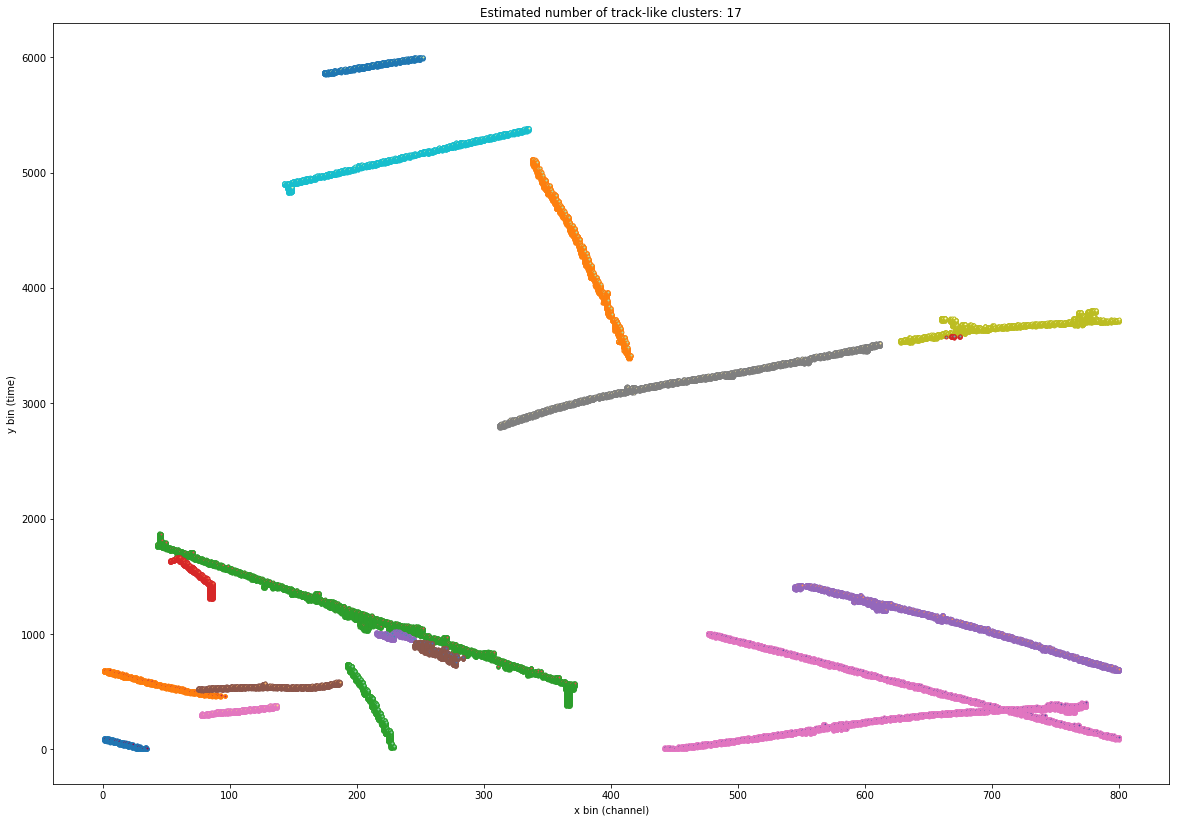

In [88]:
# Get data from csv
filename = 'hu_gauss1_orig.csv'
filename_roi = 'hu_gauss1_roi.csv'
data = np.genfromtxt(filename, delimiter=',')
data_roi = np.genfromtxt(filename_roi, delimiter=',')

X = data[:,0:2]
weight = data[:,2]
X_roi = data_roi[:,0:2]
weight_roi = data_roi[:,2]

# #############################################################################
# Compute DBSCAN

# Set parameters
eps = 5
min_samples = 30000

# Perform DBSCAN fit
db = DBSCAN(eps, min_samples).fit(X, sample_weight=weight)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

# #############################################################################
# Find track-like clusters

xspan_thresh = 10
yspan_thresh = 200
noisy_labels = [-1]

for i in range(np.max(labels)+1):
    cluster_i = X[labels == i]
    
    # tag as noise all clusters that span below threshold
    xspan = np.max(cluster_i[:,0]) - np.min(cluster_i[:,0])
    yspan = np.max(cluster_i[:,1]) - np.min(cluster_i[:,1])
    
    if (xspan < xspan_thresh) and (yspan < yspan_thresh):
        noisy_labels = np.append(noisy_labels, i)

noiseless_samples = [label not in noisy_labels for label in labels]
X_no_noise = X[noiseless_samples]
weight_no_noise = weight[noiseless_samples]
labels_no_noise = labels[noiseless_samples]

print('Estimated number of track-like clusters: %d' % len(set(labels_no_noise)), "\n")

# #############################################################################
# Compute roi efficiency (check that tracks in orig also exist in roi data)

n_samples_no_noise = np.shape(X_no_noise)[0]

print("n bins total: ", len(weight))
print("weight total: ", sum(weight))
print("bin proportion without noise: ", len(weight_no_noise)/len(weight))
print("weight proportion without noise: ", sum(weight_no_noise)/sum(weight), "\n")

i_roi = 0
intersect = []

# loop through X_no_noise and X_roi in tandem, and tag intersection (same points)
for i in range(n_samples_no_noise):
    xy = X_no_noise[i]
    xy_roi = X_roi[i_roi]
    
    while (xy_roi[0] <= xy[0] and xy_roi[1] < xy[1]) or (xy_roi[0] < xy[0]):
        i_roi += 1
        xy_roi = X_roi[i_roi]
    
    if (xy_roi[0] == xy[0]) and (xy_roi[1] == xy[1]):
        intersect.append(True)
    else:
        intersect.append(False)

# bin efficiency 
intersect_tot = intersect.count(True)
efficiency_bin = intersect_tot/n_samples_no_noise
print("n bins also in roi dataset: ", intersect_tot)
print("efficiency (bins): ", efficiency_bin)

# weight efficiency
total_weight = sum(weight_no_noise)
total_counted_weight = sum(weight_no_noise[intersect])
efficiency_weight = total_counted_weight/total_weight
print("weight also in roi dataset: ", total_counted_weight)
print("efficiency (weight): ", efficiency_weight, "\n")

# #############################################################################
# Plot results

plt.figure(figsize=(20,14))
plt.xlabel('x bin (channel)')
plt.ylabel('y bin (time)')

unique_labels = set(labels_no_noise)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels_no_noise == k)

    xy = X_no_noise[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markersize=3)

plt.title('Estimated number of track-like clusters: %d' % len(unique_labels))
plt.show()

# #############################################################################
# Save results




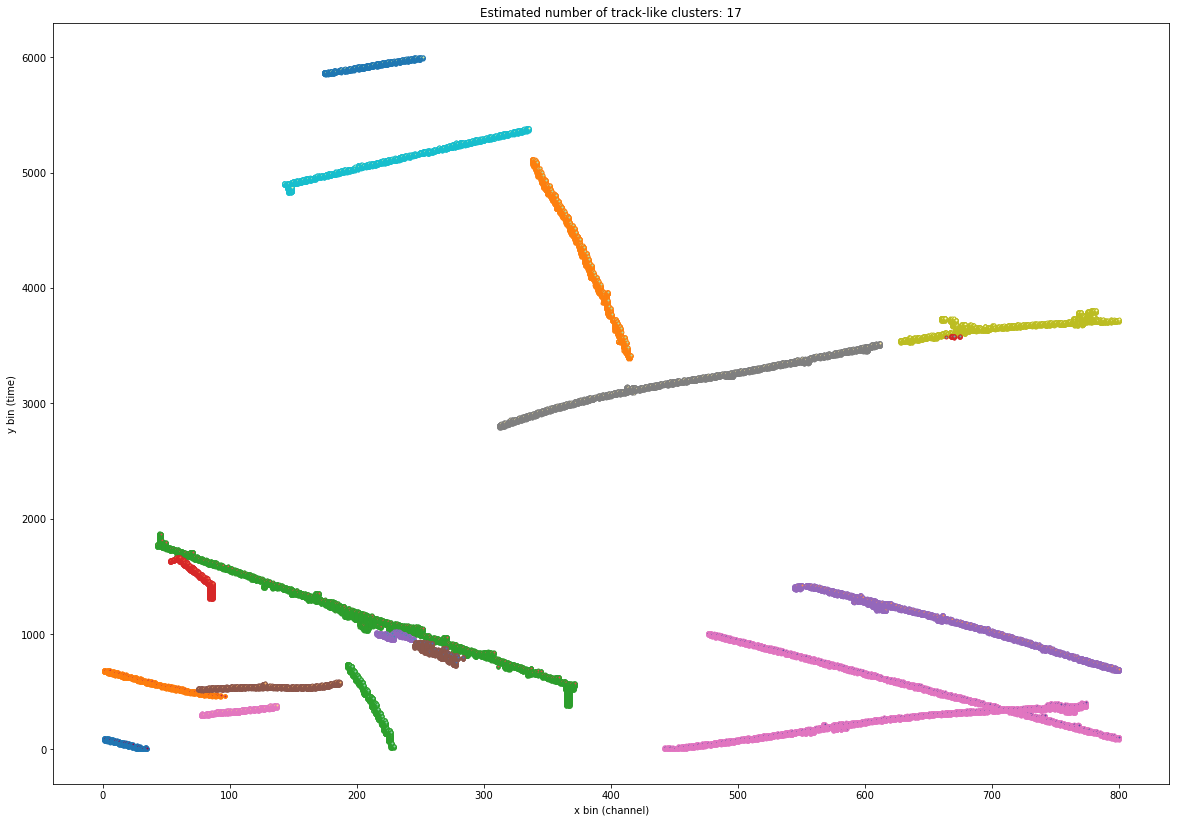

In [83]:
# Clean up clusters to only contain tracks
noisy_labels = [-1]

for i in range(np.max(labels)+1):
    cluster_i = X[labels == i]
    
    xspan = np.max(cluster_i[:,0]) - np.min(cluster_i[:,0])
    yspan = np.max(cluster_i[:,1]) - np.min(cluster_i[:,1])
    
    if (xspan < 10) and (yspan < 200):
        noisy_labels = np.append(noisy_labels, i)

noiseless_samples = [label not in noisy_labels for label in labels]
X_no_noise = X[noiseless_samples]
labels_no_noise = labels[noiseless_samples]


# #############################################################################
# Plot results

plt.figure(figsize=(20,14))
plt.xlabel('x bin (channel)')
plt.ylabel('y bin (time)')

unique_labels = set(labels_no_noise)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels_no_noise == k)

    xy = X_no_noise[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markersize=3)


plt.title('Estimated number of track-like clusters: %d' % len(unique_labels))
plt.show()

    

In [84]:
# Compute efficiency

# Find track samples uncounted by roi
X_no_noise = X[noiseless_samples]
weight_no_noise = weight[noiseless_samples]
n_samples = np.shape(X_no_noise)[0]

print("n bins: ", len(weight))
print("n bins (no noise): ", len(weight_no_noise))
print("weight proportion remaining: ", sum(weight_no_noise)/sum(weight))

i_roi = 0
intersect = []

for i in range(n_samples):
    xy = X_no_noise[i]
    xy_roi = X_roi[i_roi]
    
    while (xy_roi[0] <= xy[0] and xy_roi[1] < xy[1]) or (xy_roi[0] < xy[0]):
        i_roi += 1
        xy_roi = X_roi[i_roi]
    
    if (xy_roi[0] == xy[0]) and (xy_roi[1] == xy[1]): #and (labels_roi[i_roi] != -1)
        intersect.append(True)
    else:
        intersect.append(False)

print("\nEfficiency is calculated with noise removed from dataset \n")
        
total = intersect.count(True)
efficiency = total/n_samples
print("n bins also in roi dataset: ", total)
print("efficiency (bins): ", efficiency)

# weight uncounted by roi
total_weight = sum(weight_no_noise)
total_uncounted_weight = sum(weight_no_noise[intersect])
efficiency_weight = total_uncounted_weight/total_weight
print("efficiency (weight): ", efficiency_weight)




n bins:  101331
n bins (no noise):  85320
weight proportion remaining:  0.9194282325667406

Efficiency is calculated with noise removed from dataset 

n bins also in roi dataset:  80750
efficiency (bins):  0.9464369432723863
efficiency (weight):  0.9963983983958906


In [77]:
test = []
test = np.append(test,1)
print(test)

[1.]
